# Forecast

The stationarity of the time series for women employmenmt data was investigated in Notebook "Timeseries Analysis Stationarity".
In this notebook, some forecast models are used for prediction.


In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from scipy import signal
from sklearn.metrics import mean_absolute_error, mean_squared_error
import calendar

%matplotlib inline

# Utility functions

In [187]:
def TrainTestSplit(Df, TrainPcnt = 0.75, FcstH = 24):
    """
    Split data into training and test sets
    Df: pandas dataframe in the form of [index, values]
    TrainPcnt: percentage of data allotted for training
    FcstH: Forcast horizon
    """
    # Train-Test Split

    Len = len(Df)
    TrainLen = int(TrainPcnt * Len)
    TrainDf = Df[:TrainLen]
    TestDf = Df[TrainLen:TrainLen + ForecastH]
    return TrainDf, TestDf    


In [156]:
def PlotDiagnostics(Residu):
    """
    Plot diagnostics.
    """
    fig = plt.figure(figsize=(12,8))
    grid = plt.GridSpec(2,2, wspace=0.4, hspace=0.4)
    
    ax_resid = plt.subplot(grid[0,0])
    ax_hist = plt.subplot(grid[0,1])
    ax_qq = plt.subplot(grid[1,0])
    ax_acf = plt.subplot(grid[1,1])
    
    ax_resid.plot(Residu)
    ax_resid.set_xlabel('index')
    ax_resid.set_ylabel('residual')
    
    sns.distplot(Residu, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=ax_hist)
    ax_hist.set_xlabel('residu')
    ax_hist.set_ylabel('density')
    
    sm.qqplot(Residu.values.flatten(), fit=True, line='45', ax=ax_qq)
    
    sm.tsa.graphics.plot_acf(Residu, ax=ax_acf)

In [537]:
def PlotForecast(TrainDf, TestDf, FittedDf, ForecastDf, ModelName=''):
    """
    Plot data, fitted values and forecast values
    MdlFit: Fitted Model e.g. MdlFit = Mdl.fit()
    """
    plt.figure(figsize=(12,16))
    grid = plt.GridSpec(3,1, wspace=0.4, hspace=0.4)
    ax_data = plt.subplot(grid[0,0])
    ax_fcst = plt.subplot(grid[1,0])
    
    ax_data.plot(TrainDf,'b',label='employment data')
    ax_data.plot(FittedDf,'r', label='Fitted value '+ModelName)
    ax_data.set_ylabel('vlaue')
    ax_data.set_title('Fitted exponential smoothing, Mode: '+ModelName)
    ax_data.legend()
    
    LenTrainToPlot=len(TrainDf)//10
    ax_fcst.plot(TrainDf[-LenTrainToPlot:],'b', label='Train data')
    ax_fcst.plot(FittedDf[-LenTrainToPlot:],'r', label='fitted')
    ax_fcst.plot(TestDf,'g', label='Test data')
    ax_fcst.plot(ForecastDf,'k--', label='Forecast '+ModelName)
    
    ax_fcst.set_ylabel('vlaue')
    ax_fcst.set_title('Forecast exponential smoothing, Mode: '+ModelName)
    ax_fcst.legend()

In [ ]:
def Performance(TrainDf, TestDf, FittedDf, ForecastDf, ModelName=''):
    

In [472]:
def PlotSeasonal(TS, Period='year'):
    """
    Plot seasonal data of one time series
    TS: pandas series
    """
    # Colors
    Colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 'firebrick', 'mediumseagreen']      
    NumColors = len(Colors)
    plt.figure(figsize=(16,10), dpi= 80)
    ax = plt.subplot()
    # group by year
    TS.sort_index(inplace=True)
    gb = TS.groupby(TS.index.year)
    NumGps = gb.ngroups
    
    # plot
    Months = np.array(calendar.month_abbr)
    for i,yr in enumerate(gb.groups.keys()):
        ts = gb.get_group(yr)
        ts.index = ts.index.month
        ax.plot(ts,Colors[i%NumColors], label=yr)
        ax.text(ts.index[-1]+0.1, ts.values[-1], yr, fontsize=12, color = Colors[i%NumColors] )
    ax.set_xticks(range(13))
    ax.set_xticklabels(Months)
    plt.xlabel('Months')
    plt.ylabel('Series Value')


In [437]:
def NaivePeakTroughFinder(TS, bPlot=False):
    """
    Find peaks and troughs using differencing
    """
    TsVal = TS.values
    Diff1 = np.sign(np.diff(TsVal))
    Diff2 = np.diff(Diff1)
    PkIntIndx = np.where(Diff2==-2)[0] + 1
    TrIntIndx = np.where(Diff2== 2)[0] + 1
    
    PkIndx = TS.index[PkIntIndx]
    TrIndx = TS.index[TrIntIndx]
    
    # plot
    if(bPlot):
        plt.figure(figsize=(14,4))
        ax=plt.subplot()
        ax.plot(TS,label='time series')
        ax.plot(PkIndx, TS[PkIndx], '^r', label='Peaks')
        ax.plot(TrIndx, TS[TrIndx], 'vg', label='Trough')
    
    return PkIndx, TrIndx
    

# Women employment rate in the US
data source: https://fred.stlouisfed.org/

In [181]:
WmnEmpRate = pd.read_csv('women_emp_rate_25_52.csv') 

In [182]:
WmnEmpRate.head()

,observation_date,LREM25FEUSM156N
0,1960-01-01,39.198784
1,1960-02-01,39.678691
2,1960-03-01,39.762906
3,1960-04-01,41.099889
4,1960-05-01,41.719922


In [28]:
WmnEmpRate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    720 non-null    datetime64[ns]
 1   rate    720 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.4 KB


In [183]:
WmnEmpRate.columns=['date', 'rate']  # rename columns
WmnEmpRate['date'] = pd.to_datetime(WmnEmpRate['date']) # datetime column type
WmnEmpRate.set_index('date', inplace=True)

In [184]:
WmnEmpRate.head()

,rate
date,
1960-01-01,39.198784
1960-02-01,39.678691
1960-03-01,39.762906
1960-04-01,41.099889
1960-05-01,41.719922


## take a look at the data and the rolling mean with window = 12 months

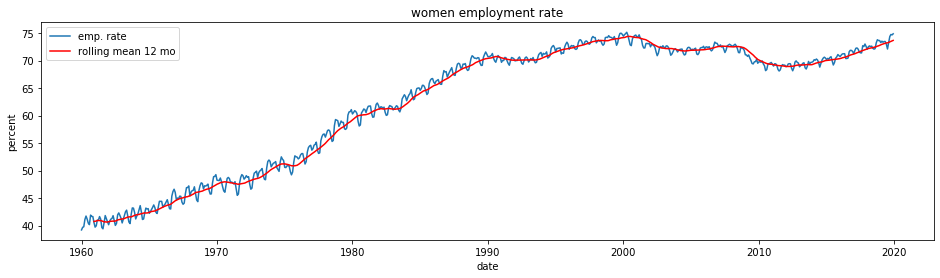

In [431]:
plt.figure(figsize=(16,4))
plt.plot(WmnEmpRate,label='emp. rate')
plt.plot(WmnEmpRate.rolling(12).mean(), 'r',label='rolling mean 12 mo' )
plt.xlabel('date')
plt.ylabel('percent')
plt.title('women employment rate')
plt.legend()


There is clearly a trand in the mean, but the variance seems to be stable. There are many ways to remove the trend in the data.
For time series for which the waveform morphology is important, it's better to use a technique with minimal distorsion to the waveform; for example, a zero distortion high pass FIR filtering. Other methods such as differencing are as effective for many
applications.


# Forecasting: Exponential Smoothing (ES)

Exponential smoothing are simple and fast forecasting algorithms. Table below list the caplability of these
forecasting schemes in handeling time series with various characteristics.

Algorithm| stationary | trend |seasonality|
--|--|--|--|
Simple ES| y | - |-|
Holt's ES| y | y |-|
Winter's ES| y | y |y|

In simple ES,
$$\hat{y}_{t+h|t} = L_t$$
$$L_t = \alpha Y_{t-1} + (1-\alpha) L_{t-1}$$
the level $L_t$ is updated as a weighted average of the value at $t$ and the previous level
where $0 \le \alpha \le 1$.

Holt improved the forecast for time series with trend 
$$\hat{y}_{t+h|t} = L_t + h\, T_t$$
$$L_t = \alpha Y_t + (1-\alpha) (L_{t-1} + T_{t-1})$$
$$T_t = \beta (L_t - L_{t-1}) + (1-\beta) T_{t-1}$$
where trend $T_t$ is updated as a weigthed avergae of the current and previous 

With Winter's improvement the seasonality can be incorporated into model.

## Train-Test Split

In [500]:
TrainPcnt = 0.75
FcstH = 24
TrainDf, TestDf = TrainTestSplit(WmnEmpRate, TrainPcnt, FcstH)
print("Train len: {0:d}, Test len: {1:d}".format(len(TrainDf), len(TestDf)))

Train len: 540, Test len: 24


## Simple Exponential Smoothing (SES)

In [199]:
SESMdl = SimpleExpSmoothing(TrainDf)

c:\users\name\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [503]:
SESFit = SESMdl.fit(smoothing_level=.2)
#PredSES = SESFit.forecast(FcstH)
PredSES = SESFit.predict(start=TestDf.index[0],end=TestDf.index[-1])

c:\users\name\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [501]:
SESFit.summary()

Dep. Variable:,endog,No. Observations:,540
Model:,SimpleExpSmoothing,SSE,458.911
Optimized:,True,AIC,-83.864
Trend:,None,BIC,-75.281
Seasonal:,None,AICC,-83.790
Seasonal Periods:,None,Date:,"Tue, 18 Feb 2020"
Box-Cox:,False,Time:,18:09:48
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
initial_level,40.303298,l.0,True


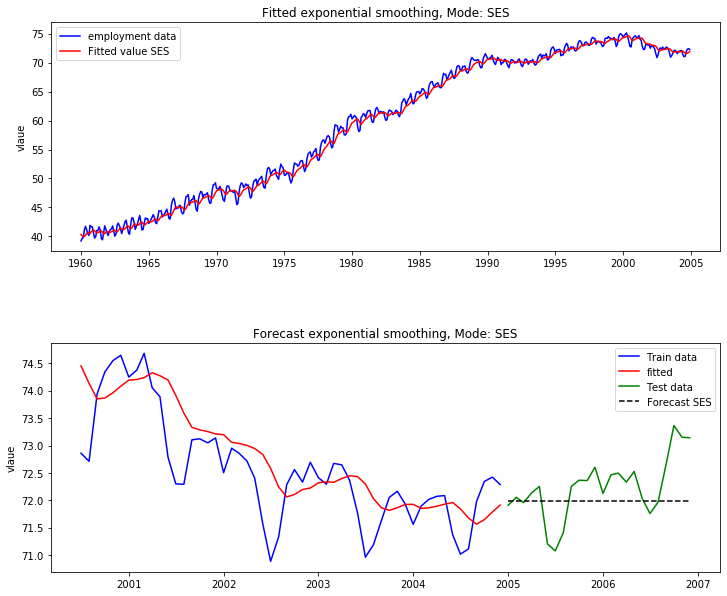

In [538]:
PlotForecast(TrainDf, TestDf, SESFit.fittedvalues, PredSES, 'SES')

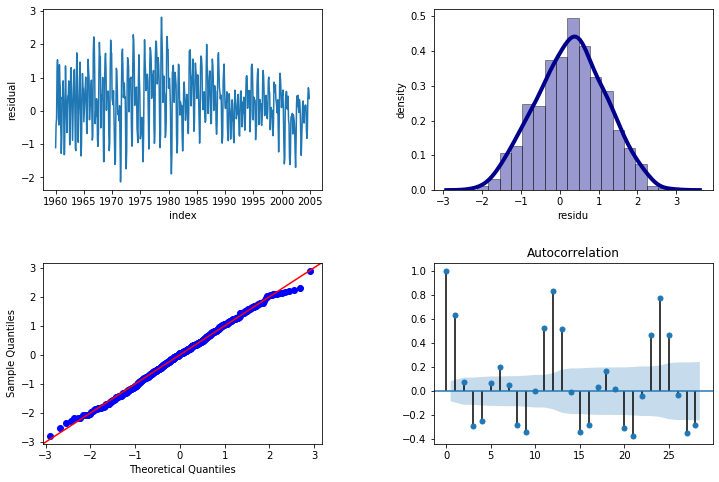

In [527]:
PlotDiagnostics(SESFit.resid)

## Holt's Exponentail Smoothing HES

In [534]:
HESMdl = Holt(TrainDf)
HESFit = HESMdl.fit(smoothing_level=0.2, smoothing_slope=0.2)

c:\users\name\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [535]:
PredHES = HESFit.predict(start=TestDf.index[0],end=TestDf.index[-1])

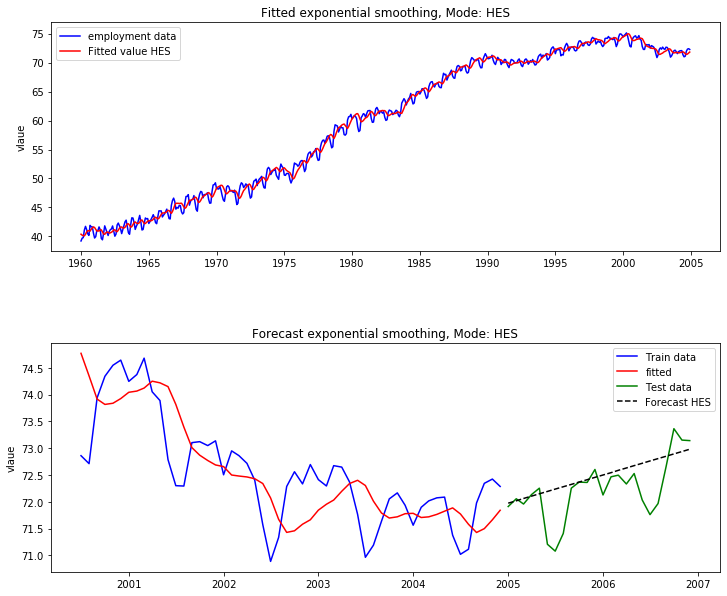

In [539]:
PlotForecast(TrainDf, TestDf, HESFit.fittedvalues, PredHES, 'HES')

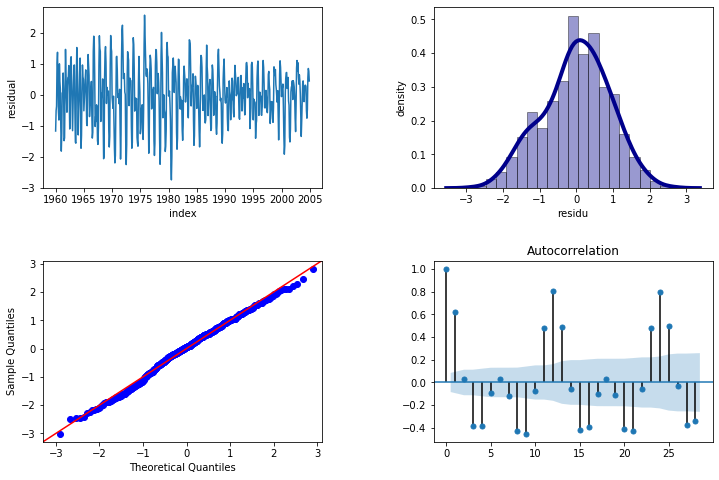

In [551]:
PlotDiagnostics(HESFit.resid)

In [546]:
HESFit.summary()

Dep. Variable:,endog,No. Observations:,540
Model:,Holt,SSE,447.319
Optimized:,True,AIC,-93.680
Trend:,Additive,BIC,-76.514
Seasonal:,None,AICC,-93.523
Seasonal Periods:,None,Date:,"Tue, 18 Feb 2020"
Box-Cox:,False,Time:,18:26:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_slope,0.2000000,beta,False


## Winter's Exponential Smoothing WES

In [561]:
WESMdl = ExponentialSmoothing(TrainDf, trend='add', seasonal='add', seasonal_periods=12, damped=False)
WESFit = WESMdl.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.3)

c:\users\name\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [562]:
PredWES = WESFit.predict(start=TestDf.index[0],end=TestDf.index[-1])

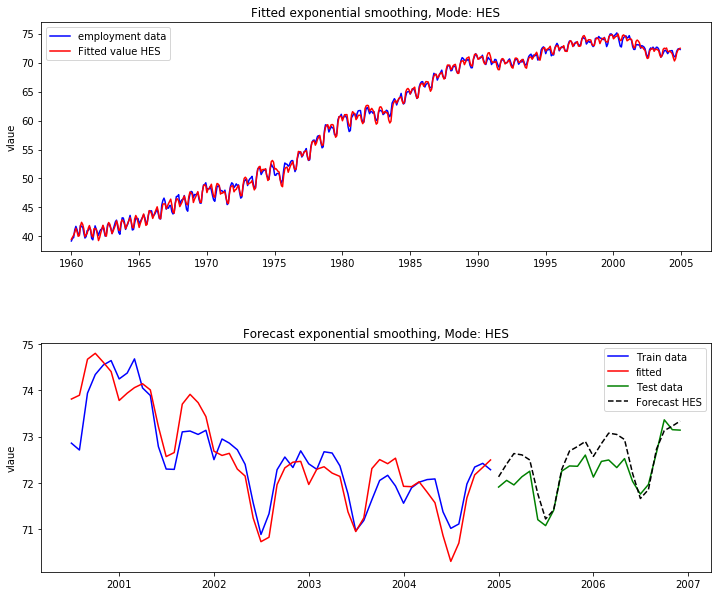

In [563]:
PlotForecast(TrainDf, TestDf, WESFit.fittedvalues, PredWES, 'HES')

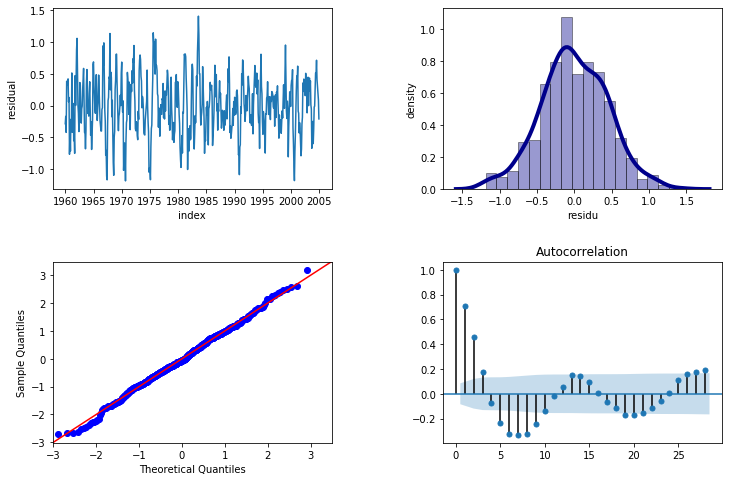

In [564]:
PlotDiagnostics(WESFit.resid)

In [550]:
WESFit.summary()

Dep. Variable:,endog,No. Observations:,540
Model:,ExponentialSmoothing,SSE,99.657
Optimized:,True,AIC,-878.511
Trend:,Additive,BIC,-805.555
Seasonal:,Additive,AICC,-877.050
Seasonal Periods:,12,Date:,"Tue, 18 Feb 2020"
Box-Cox:,False,Time:,18:27:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_slope,0.2000000,beta,False
